<font color=black size=5 face=雅黑>1.获取街景图像</font>

In [22]:
# -*- coding: utf-8 -*-

import requests, json, re, os, random, time, math

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626 # π
a = 6378245.0 # 长半轴
ee = 0.00669342162296594323 # 扁率
#百度墨卡托投影纠正矩阵
LLBAND =[75, 60, 45, 30, 15, 0]
LL2MC = [[-0.0015702102444, 111320.7020616939, 1704480524535203, -10338987376042340, 26112667856603880, -35149669176653700, 26595700718403920, -10725012454188240, 1800819912950474, 82.5],
         [0.0008277824516172526, 111320.7020463578, 647795574.6671607, -4082003173.641316, 10774905663.51142, -15171875531.51559, 12053065338.62167, -5124939663.577472, 913311935.9512032, 67.5],
         [0.00337398766765, 111320.7020202162, 4481351.045890365, -23393751.19931662, 79682215.47186455, -115964993.2797253, 97236711.15602145, -43661946.33752821, 8477230.501135234, 52.5],
         [0.00220636496208, 111320.7020209128, 51751.86112841131, 3796837.749470245, 992013.7397791013, -1221952.21711287, 1340652.697009075, -620943.6990984312, 144416.9293806241, 37.5],
         [-0.0003441963504368392, 111320.7020576856, 278.2353980772752, 2485758.690035394, 6070.750963243378, 54821.18345352118, 9540.606633304236, -2710.55326746645, 1405.483844121726, 22.5],
         [-0.0003218135878613132, 111320.7020701615, 0.00369383431289, 823725.6402795718, 0.46104986909093, 2351.343141331292, 1.58060784298199, 8.77738589078284, 0.37238884252424, 7.45]]
# 百度墨卡托转回到百度经纬度纠正矩阵
MCBAND = [12890594.86, 8362377.87, 5591021, 3481989.83, 1678043.12, 0]
MC2LL = [[1.410526172116255e-8, 0.00000898305509648872, -1.9939833816331, 200.9824383106796, -187.2403703815547, 91.6087516669843, -23.38765649603339, 2.57121317296198, -0.03801003308653, 17337981.2],
      [-7.435856389565537e-9, 0.000008983055097726239, -0.78625201886289, 96.32687599759846, -1.85204757529826, -59.36935905485877, 47.40033549296737, -16.50741931063887, 2.28786674699375, 10260144.86],
      [-3.030883460898826e-8, 0.00000898305509983578, 0.30071316287616, 59.74293618442277, 7.357984074871, -25.38371002664745, 13.45380521110908, -3.29883767235584, 0.32710905363475, 6856817.37],
      [-1.981981304930552e-8, 0.000008983055099779535, 0.03278182852591, 40.31678527705744, 0.65659298677277, -4.44255534477492, 0.85341911805263, 0.12923347998204, -0.04625736007561, 4482777.06],
      [3.09191371068437e-9, 0.000008983055096812155, 0.00006995724062, 23.10934304144901, -0.00023663490511, -0.6321817810242, -0.00663494467273, 0.03430082397953, -0.00466043876332, 2555164.4],
      [2.890871144776878e-9, 0.000008983055095805407, -3.068298e-8, 7.47137025468032, -0.00000353937994, -0.02145144861037, -0.00001234426596, 0.00010322952773, -0.00000323890364, 826088.5]]
def gcj02tobd09(lng, lat):
    """
    火星坐标系(GCJ02)转百度坐标系(BD09)
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
 
def bd09togcj02(bd_lon, bd_lat):
    """
    百度坐标系(BD09)转火星坐标系(GCJ02)
    :param bd_lat:百度坐标纬度
    :param bd_lon:百度坐标经度
    :return:转换后的坐标列表形式
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
 
def wgs84togcj02(lng, lat):
    """
    WGS84转GCJ02(火星坐标系)
    :param lng:WGS84坐标系的经度
    :param lat:WGS84坐标系的纬度
    :return:
    """
    if out_of_china(lng, lat): # 判断是否在国内
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
 
def wgstobd09(lon, lat):
    tmplon, tmplat = wgs84togcj02(lon, lat)
    return gcj02tobd09(tmplon, tmplat)

def wgstobdmc(lon, lat):
    tmplon, tmplat = wgstobd09(lon, lat)
    return bd09tomercator(tmplon, tmplat)
 
def gcj02towgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    if out_of_china(lng, lat):
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
 
def transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + 0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
    math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
    math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
 
def transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + 0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
 
def out_of_china(lng, lat):
    """
    判断是否在国内，不在国内不做偏移
    :param lng:
    :param lat:
    :return:
    """
    if lng < 72.004 or lng > 137.8347:
        return True
    if lat < 0.8293 or lat > 55.8271:
        return True
    return False
 
def wgs84tomercator(lng,lat):
    """
    wgs84投影到墨卡托
    :param lng:
    :param lat:
    :return:
    """
    x = lng * 20037508.34 / 180
    y = math.log(math.tan((90 + lat) * math.pi / 360)) / (math.pi / 180) * 20037508.34 / 180
    return x,y
def mercatortowgs84(x,y):
    """
    墨卡托投影坐标转回wgs84
    :param x:
    :param y:
    :return:
    """
    lng = x / 20037508.34 * 180
    lat = 180 / math.pi * (2 * math.atan(math.exp(y / 20037508.34 * 180 * math.pi / 180)) - math.pi / 2)
    return lng,lat
 
def getRange(cC, cB, T):
    if (cB != None):
        cC = max(cC, cB)
    if (T != None):
        cC = min(cC, T)
    return cC
 
def getLoop(cC, cB, T):
    while (cC > T):
        cC -= T - cB
    while (cC < cB):
        cC += T - cB
    return cC
 
def convertor(cC, cD):
    if (cC==None or cD==None):
        print('null')
        return None
    T = cD[0] + cD[1] * abs(cC.x)
    cB = abs(cC.y) / cD[9]
    cE = cD[2] + cD[3] * cB + cD[4] * cB * cB +cD[5] * cB * cB * cB + cD[6] * cB * cB * cB * cB +cD[7] * cB * cB * cB * cB * cB +cD[8] * cB * cB * cB * cB * cB * cB
    if(cC.x<0):
        T=T*-1
    else:
        T=T
    if(cC.y<0):
        cE=cE*-1
    else:
        cE=cE
    return [T, cE]
 
def convertLL2MC(T) :
    cD=None
    T.x = getLoop(T.x, -180, 180)
    T.y = getRange(T.y, -74, 74)
    cB = T
    for cC in range(0,len(LLBAND),1):
        if (cB.y >= LLBAND[cC]) :
            cD = LL2MC[cC]
            break
    if (cD!=None) :
        for cC in range(len(LLBAND) - 1,-1,-1):
            if (cB.y <= -LLBAND[cC]):
                cD = LL2MC[cC]
                break
    cE = convertor(T, cD)
    return cE
 
def convertMC2LL(cB):
    cC=LLT(abs(cB.x),abs(cB.y))
    cE=None
    for cD in range(0,len(MCBAND),1):
        if (cC.y >= MCBAND[cD]) :
            cE = MC2LL[cD]
            break
    T = convertor(cB, cE)
    return T
 
def bd09tomercator(lng,lat):
    """
    bd09投影到百度墨卡托
    :param lng:
    :param lat:
    :return:
    """
    baidut=LLT(lng,lat)
    return convertLL2MC(baidut)
def mercatortobd09(x,y):
    """
    墨卡托投影坐标转回bd09
    :param x:
    :param y:
    :return:
    """
    baidut=LLT(x,y)
    return convertMC2LL(baidut)
 
class LLT:
    def __init__(self,x,y):
        self.x=x
        self.y=y
 
def Random_choose_useragent():

    ualist = ['Opera/9.80 (Windows NT 6.1; U; cs) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1866.237 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/4.0; InfoPath.1; SV1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 3.0.04506.30)', 'Mozilla/5.0 (X11; Linux; rv:74.0) Gecko/20100101 Firefox/74.0', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.13; ko; rv:1.9.1b2) Gecko/20081201 Firefox/60.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36',  'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20130401 Firefox/31.0', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.62 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)', 
            'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.2 Safari/537.36', 'Mozilla/5.0 (X11; Ubuntu; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2820.59 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_6; zh-cn) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.4 Safari/533.20.27', 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_5; ar) AppleWebKit/533.19.4 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Opera/9.80 (Windows NT 5.2; U; ru) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2117.157 Safari/537.36', 'Mozilla/4.0 (Compatible; MSIE 8.0; Windows NT 5.2; Trident/6.0)', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36', 'Mozilla/5.0 (Windows; U; Windows NT 5.1; ja-JP) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1467.0 Safari/537.36']
    headers = {
        'User-Agent': random.choice(ualist)}
    return headers


def xy_to_sid(x, y, input_params):

    params = {
        "udt": input_params['date'],
        "action": 0,
        'x': x,
        'y': y,
        'l': 18.367179030452565,
        "mode": 'day',
        't': 1553246985040,
        'fn': 'jsonp69972182',
        'qt':'qsdata'
    }     

    try:
        r = requests.get("https://mapsv0.bdimg.com/?", params, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        jsonstr = str1.split('(')[1].split(')')[0]
        j = json.loads(jsonstr)
        if j["result"]["error"] == 0:
            # sid_x, sid_y = j['content']['x'], j['content']['y']
            # if ((x-sid_x)**2+(y-sid_y)**2)**0.5>=300: #获取到的街景距离采样点过远
            #     print('距离过远，无街景')
            #     return -1

            sid = j['content']['id']
            return sid
        else:#如果error不为0，说明这个坐标点没有街景影像
            print("无街景")
            return -1
    except Exception as e:
        print("x,y to sid失败！")
        print(str(e))


# sid to datetime  sid得到时间轴，通过时间轴抓取对应时间的图像
# 输入参数分别 点对应的sid，百度坐标x，y，点序号
def sid_to_date_img(sid, trueX, trueY, wgslon, wgslat, rid, input_params):
    bdsid_param = {
        'sid': sid,
        'pc':1,
        'udt': input_params['date'],
        'fn': 'jsonp.p3991630',
        'qt':'sdata'
    }
    try:
        # 一个采样点可能有在数个时间点采集的街景影像，这里根据采样点标识ID获取最新的采样点-时间标识ID
        # 同时获取采样点对应的道路的走向，以获得视角与道路走向平行或垂直的街景影像
        r = requests.get("https://mapsv0.bdimg.com/?", bdsid_param, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        p2 = re.compile(r'[(](.*)[)]', re.S)  # 贪婪匹配
        jsonstr2 = str(re.findall(p2, str1)[0])
        j = json.loads(jsonstr2)
        direction = float(j['content'][0]['MoveDir'])   # 获取道路的方位
        timeid =  j['content'][0]['TimeLine'][0]['ID']
        #遍历希望获取的数个方向
        for head in input_params['directions']:
            bdimg_params = {
                'fovy': 90,
                'quality': 90,
                'panoid': timeid,     # panoid 与sid对应
                'heading': (head+direction)%360,
                'width': 512,
                'height': 512,
                'qt':'pr3d'
            }
            try:
                r = requests.get("https://mapsv0.bdimg.com/?", bdimg_params,  headers = input_params['headers'], timeout = (3,7))
            except Exception as e:
                print(str(e))
            #如果获取成功，就保存影像
            if r.headers['Content-Type'] == 'image/jpeg':
                savedir = f"{input_params['outpath']}"
                savepath = f"{savedir}/{rid}_{wgslon}_{wgslat}_{head}.png"
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                open(savepath, 'wb').write(r.content)
        #写日志
        with open('xy_sid2.txt', 'a') as f:
            f.write("{0},{1},{2}\n".format(trueX, trueY, timeid))

        with open('error2.txt', 'a')  as f:# 记录抓到第几个街景
            f.write("{0},{1},{2}\n".format(rid, trueX, trueY))
            
    except Exception as e:
        print("sid to img失败！")
        print(str(e))

        
# 百度坐标得到街景图片
# 参数 百度坐标X、Y、点序号
def xy_to_img(x, y, lon, lat, rid, input_params):
    sid = xy_to_sid(x, y, input_params)#先根据坐标获取街景采样点的唯一标识ID
    if sid != -1:
        sid_to_date_img(sid, x, y, lon, lat, rid, input_params)
        print(rid)
        
# 输入经纬度得到街景相片
# 参数 经度、纬度、点序号
def lon_lat_to_img(lon, lat, rid, input_params):
    x, y = wgstobdmc(lon, lat)#先将WGS1984坐标转为百度墨卡托坐标
    xy_to_img(x, y, lon, lat, rid, input_params)#使用百度墨卡托坐标获取街景影像

def ReadRID(filename):
    if not os.path.exists(filename):
        f = open(filename, 'w')
        f.close()
        return 1
    with open(filename, 'r') as f:
        num_str = f.readlines()[-1]
        num = int(num_str.split(',')[0])
    return num


In [24]:
if __name__ == '__main__':
    #街景点坐标csv
    input_points = "D:/desk/JNU/point.csv"
    #部分参数
    input_params = {
        'outpath':'D:/desk/JNU/JUNimg/total',# 存放街景影像的输出路径
        'directions':[0,90,180,270],# 获取的方向
        'headers':Random_choose_useragent(),#请求头
        'date':time.strftime("%Y%m%d", time.localtime()) 
    }
    #创建储存结果的文件夹
    if not os.path.exists(input_params['outpath']):
        os.mkdir(input_params['outpath'])
    filelist = os.listdir(input_params['outpath'])
    # 打开坐标csv文件
    with open(input_points, 'r') as data:
        lines = data.readlines()[1:]
        for line in lines:
            line = line.strip()
            rid = line.split(',')[0]
            wgslon = float(line.split(',')[1])
            wgslat = float(line.split(',')[2])
            if rid not in filelist:  # 已有直接跳过
                s = time.time()
                if random.random() < 0.2:  # 0.2 的概率需要sleep
                    time.sleep(random.random()) # 随机休息0-2秒
                try:
                    lon_lat_to_img(wgslon, wgslat, rid, input_params)
                except Exception as e:
                    print(rid,repr(e))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
HTTPSConnectionPool(host='mapsv0.bdimg.com', port=443): Max retries exceeded with url: /?fovy=90&quality=90&panoid=09000100121708021138251495Y&heading=246.495&width=512&height=512&qt=pr3d (Caused by ProxyError('Cannot connect to proxy.', timeout('_ssl.c:1106: The handshake operation timed out')))
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
162
163
164
165
166
167
168
169
170
172
173
174
175
176
177
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
20

<font color=black size=5 face=雅黑>2.对街景图像进行重新命名“xx_1.jpg”</font>

In [40]:
# -*- coding:utf8 -*-

#import os

class BatchRename():
    '''
    批量重命名文件夹中的图片文件

    '''
    def __init__(self):
        self.path = r'D:/desk/JNU/JUNimg/4/'  #表示需要命名处理的文件夹

    def rename(self):
        filelist = os.listdir(self.path) #获取文件路径
        total_num = filelist.sort(key=lambda x:int(x.split('_')[0])) #获取文件长度（个数）
        i = 1  #表示文件的命名是从1开始的
        for item in filelist:
            if item.endswith('.png'):  #初始的图片的格式为jpg格式的（或者源文件是png格式及其他格式，后面的转换格式就可以调整为自己需要的格式即可）
                src = os.path.join(os.path.abspath(self.path), item)
                #dst = os.path.join(os.path.abspath(self.path), ''+str(i) + '.jpg')#处理后的格式也为jpg格式的，当然这里可以改成png格式
                dst = os.path.join(os.path.abspath(self.path), format(str(i)+'_4') + '.jpg')    #这种情况下的命名格式为0000000.jpg形式，可以自主定义想要的格式
                try:
                    os.rename(src, dst)
                    print ('converting %s to %s ...' % (src, dst))
                    i = i + 1
                except:
                    continue
        #print ('total %d to rename & converted %d jpgs' % (total_num, i))

if __name__ == '__main__':
    demo = BatchRename()
    demo.rename()

converting D:\desk\JNU\JUNimg\4\1_120.268178536341_31.4938807884827_270.png to D:\desk\JNU\JUNimg\4\1_4.jpg ...
converting D:\desk\JNU\JUNimg\4\2_120.268208734108_31.4935621231546_270.png to D:\desk\JNU\JUNimg\4\2_4.jpg ...
converting D:\desk\JNU\JUNimg\4\3_120.268238930976_31.4932434567406_270.png to D:\desk\JNU\JUNimg\4\3_4.jpg ...
converting D:\desk\JNU\JUNimg\4\4_120.268241240545_31.4929758774399_270.png to D:\desk\JNU\JUNimg\4\4_4.jpg ...
converting D:\desk\JNU\JUNimg\4\5_120.268243551011_31.4927082973736_270.png to D:\desk\JNU\JUNimg\4\5_4.jpg ...
converting D:\desk\JNU\JUNimg\4\6_120.26824586058_31.4924407165417_270.png to D:\desk\JNU\JUNimg\4\6_4.jpg ...
converting D:\desk\JNU\JUNimg\4\7_120.26847306877_31.4931662175993_270.png to D:\desk\JNU\JUNimg\4\7_4.jpg ...
converting D:\desk\JNU\JUNimg\4\8_120.268702407764_31.4931460198233_270.png to D:\desk\JNU\JUNimg\4\8_4.jpg ...
converting D:\desk\JNU\JUNimg\4\9_120.269247531529_31.4936663110883_270.png to D:\desk\JNU\JUNimg\4\9_4.jp

converting D:\desk\JNU\JUNimg\4\432_120.268897188568_31.4882633567993_270.png to D:\desk\JNU\JUNimg\4\428_4.jpg ...
converting D:\desk\JNU\JUNimg\4\433_120.269563006382_31.488425698034_270.png to D:\desk\JNU\JUNimg\4\429_4.jpg ...
converting D:\desk\JNU\JUNimg\4\434_120.269233668728_31.4884415250713_270.png to D:\desk\JNU\JUNimg\4\430_4.jpg ...
converting D:\desk\JNU\JUNimg\4\435_120.269580440885_31.4887441441589_270.png to D:\desk\JNU\JUNimg\4\431_4.jpg ...
converting D:\desk\JNU\JUNimg\4\436_120.269934294462_31.4884854303206_270.png to D:\desk\JNU\JUNimg\4\432_4.jpg ...
converting D:\desk\JNU\JUNimg\4\437_120.269837950148_31.4887740102053_270.png to D:\desk\JNU\JUNimg\4\433_4.jpg ...
converting D:\desk\JNU\JUNimg\4\438_120.270217975242_31.488204639369_270.png to D:\desk\JNU\JUNimg\4\434_4.jpg ...
converting D:\desk\JNU\JUNimg\4\439_120.272098065589_31.4886705583411_270.png to D:\desk\JNU\JUNimg\4\435_4.jpg ...
converting D:\desk\JNU\JUNimg\4\440_120.27158810907_31.4884280037978_270.p

converting D:\desk\JNU\JUNimg\4\858_120.265523755962_31.4817542840761_270.png to D:\desk\JNU\JUNimg\4\840_4.jpg ...
converting D:\desk\JNU\JUNimg\4\859_120.265195937358_31.4815004898971_270.png to D:\desk\JNU\JUNimg\4\841_4.jpg ...
converting D:\desk\JNU\JUNimg\4\860_120.265196129598_31.4812573858608_270.png to D:\desk\JNU\JUNimg\4\842_4.jpg ...
converting D:\desk\JNU\JUNimg\4\861_120.265896167834_31.4814986865184_270.png to D:\desk\JNU\JUNimg\4\843_4.jpg ...
converting D:\desk\JNU\JUNimg\4\862_120.265940567965_31.4812323958975_270.png to D:\desk\JNU\JUNimg\4\844_4.jpg ...
converting D:\desk\JNU\JUNimg\4\863_120.268600744525_31.4817773663384_270.png to D:\desk\JNU\JUNimg\4\845_4.jpg ...
converting D:\desk\JNU\JUNimg\4\864_120.26824295453_31.4815056717378_270.png to D:\desk\JNU\JUNimg\4\846_4.jpg ...
converting D:\desk\JNU\JUNimg\4\866_120.261279303381_31.4809097344234_270.png to D:\desk\JNU\JUNimg\4\847_4.jpg ...
converting D:\desk\JNU\JUNimg\4\867_120.261062808499_31.4806946956152_270

<font color=black size=5 face=雅黑>3.合并图像</font>

In [41]:
# This code is used to tile together the four directions of the street view image from the street point
import os
from PIL import Image

# Control of image quality, value range 1 to 100
quality_value = 100
# Original image save path
original_path = r'D:/desk/JNU/JUNimg/rename'
# joint image save path
joint_path = r'D:/desk/JNU/save_joint_images'

#  Get all image paths under a file
image_open = [Image.open(original_path+'\\'+fn) for fn in os.listdir(original_path)]

In [42]:
img_name=[]
for file_name in os.listdir(original_path):
    print(file_name)
    img_name.append(file_name)

1000_1.jpg
1000_2.jpg
1000_3.jpg
1000_4.jpg
1001_1.jpg
1001_2.jpg
1001_3.jpg
1001_4.jpg
1002_1.jpg
1002_2.jpg
1002_3.jpg
1002_4.jpg
1003_1.jpg
1003_2.jpg
1003_3.jpg
1003_4.jpg
1004_1.jpg
1004_2.jpg
1004_3.jpg
1004_4.jpg
1005_1.jpg
1005_2.jpg
1005_3.jpg
1005_4.jpg
1006_1.jpg
1006_2.jpg
1006_3.jpg
1006_4.jpg
1007_1.jpg
1007_2.jpg
1007_3.jpg
1007_4.jpg
1008_1.jpg
1008_2.jpg
1008_3.jpg
1008_4.jpg
1009_1.jpg
1009_2.jpg
1009_3.jpg
1009_4.jpg
100_1.jpg
100_2.jpg
100_3.jpg
100_4.jpg
1010_1.jpg
1010_2.jpg
1010_3.jpg
1010_4.jpg
1011_1.jpg
1011_2.jpg
1011_3.jpg
1011_4.jpg
1012_1.jpg
1012_2.jpg
1012_3.jpg
1012_4.jpg
1013_1.jpg
1013_2.jpg
1013_3.jpg
1013_4.jpg
1014_1.jpg
1014_2.jpg
1014_3.jpg
1014_4.jpg
1015_1.jpg
1015_2.jpg
1015_3.jpg
1015_4.jpg
1016_1.jpg
1016_2.jpg
1016_3.jpg
1016_4.jpg
1017_1.jpg
1017_2.jpg
1017_3.jpg
1017_4.jpg
1018_1.jpg
1018_2.jpg
1018_3.jpg
1018_4.jpg
1019_1.jpg
1019_2.jpg
1019_3.jpg
1019_4.jpg
101_1.jpg
101_2.jpg
101_3.jpg
101_4.jpg
1020_1.jpg
1020_2.jpg
1020_3.jpg
1020_4.

In [43]:
# Images converted to the same size
#image_resize = []
#for img in image_open:
#    new_img = img.resize((512, 512), Image.ANTIALIAS)
#    image_resize.append(new_img)

def joint_pic(img_list,number):
    img_list = img_list[0]
    #print(img_list)
    # Single image size
    width, height = img_list[0].size
    # Create a long blank image
    # white = Image.new(img_list[0].mode, (width, height * len(ims)))
    white = Image.new(img_list[0].mode, (width * len(img_list), height))
    # joint image
    for i, image in enumerate(img_list):
        # result.paste(image, box=(0, i * height))
        white.paste(image, box=(i * width, 0))
    # save the image
    white.save(os.path.join(joint_path,str(number)+'_out.jpg'),quality=quality_value)
#"+img_name[i*num+j][0:-6]+"_out.jpg"
# Grouping lists into groups of 4
for j,count in enumerate(range(0,len(image_open),4)):
    j += 1
    # print(j,count)
    group = []
    group.append(image_open[count:count+4])
    # print(image_resize)
    # print(group)
    joint_pic(group,j)
    print('process the ' + str(j) + ' iamge')

process the 1 iamge
process the 2 iamge
process the 3 iamge
process the 4 iamge
process the 5 iamge
process the 6 iamge
process the 7 iamge
process the 8 iamge
process the 9 iamge
process the 10 iamge
process the 11 iamge
process the 12 iamge
process the 13 iamge
process the 14 iamge
process the 15 iamge
process the 16 iamge
process the 17 iamge
process the 18 iamge
process the 19 iamge
process the 20 iamge
process the 21 iamge
process the 22 iamge
process the 23 iamge
process the 24 iamge
process the 25 iamge
process the 26 iamge
process the 27 iamge
process the 28 iamge
process the 29 iamge
process the 30 iamge
process the 31 iamge
process the 32 iamge
process the 33 iamge
process the 34 iamge
process the 35 iamge
process the 36 iamge
process the 37 iamge
process the 38 iamge
process the 39 iamge
process the 40 iamge
process the 41 iamge
process the 42 iamge
process the 43 iamge
process the 44 iamge
process the 45 iamge
process the 46 iamge
process the 47 iamge
process the 48 iamge
p

process the 380 iamge
process the 381 iamge
process the 382 iamge
process the 383 iamge
process the 384 iamge
process the 385 iamge
process the 386 iamge
process the 387 iamge
process the 388 iamge
process the 389 iamge
process the 390 iamge
process the 391 iamge
process the 392 iamge
process the 393 iamge
process the 394 iamge
process the 395 iamge
process the 396 iamge
process the 397 iamge
process the 398 iamge
process the 399 iamge
process the 400 iamge
process the 401 iamge
process the 402 iamge
process the 403 iamge
process the 404 iamge
process the 405 iamge
process the 406 iamge
process the 407 iamge
process the 408 iamge
process the 409 iamge
process the 410 iamge
process the 411 iamge
process the 412 iamge
process the 413 iamge
process the 414 iamge
process the 415 iamge
process the 416 iamge
process the 417 iamge
process the 418 iamge
process the 419 iamge
process the 420 iamge
process the 421 iamge
process the 422 iamge
process the 423 iamge
process the 424 iamge
process th

process the 760 iamge
process the 761 iamge
process the 762 iamge
process the 763 iamge
process the 764 iamge
process the 765 iamge
process the 766 iamge
process the 767 iamge
process the 768 iamge
process the 769 iamge
process the 770 iamge
process the 771 iamge
process the 772 iamge
process the 773 iamge
process the 774 iamge
process the 775 iamge
process the 776 iamge
process the 777 iamge
process the 778 iamge
process the 779 iamge
process the 780 iamge
process the 781 iamge
process the 782 iamge
process the 783 iamge
process the 784 iamge
process the 785 iamge
process the 786 iamge
process the 787 iamge
process the 788 iamge
process the 789 iamge
process the 790 iamge
process the 791 iamge
process the 792 iamge
process the 793 iamge
process the 794 iamge
process the 795 iamge
process the 796 iamge
process the 797 iamge
process the 798 iamge
process the 799 iamge
process the 800 iamge
process the 801 iamge
process the 802 iamge
process the 803 iamge
process the 804 iamge
process th

<font color=black size=5 face=雅黑>4.打分系统</font>

In [8]:
# You can deploy this code on a cloud server to collect perception scores for street view images
import os
import cv2
import csv
import codecs
import os

# street view save path
read_path = r'D:/desk/JNU/samples/'
# perception result file name
fileName = 'D:/desk/JNU/scores/Score.csv'
# perception result file save path
save_path = r'D:/desk/JNU/scores/score_save/'

num = 0
imagelist = os.listdir(read_path)

print('Please observe the street view image for 5 seconds\nAnd enter a number between 1 and 100 for the score')
for imgname in imagelist:
    print('Remaining ', len(imagelist)-num, ' images.', end='')
    image = cv2.imread(read_path + imgname)
    cv2.imshow(imgname, image)
    # k = cv2.waitKey(0)
    cv2.waitKey(2000)
    cv2.destroyWindow(imgname)
    print(' The ',num,' image ',end='')
    num += 1
    score = input("perception score is:")

    if int(score) < 101:
        # writte result in csv file
        with codecs.open(fileName, 'a', 'utf-8') as csvfile:
            filednames = [imgname, score]
            writer = csv.DictWriter(csvfile, fieldnames=filednames)
            writer.writeheader()

        # Store the scoring results in the corresponding folder
        if not os.path.exists(save_path + '/' + score):
            os.makedirs(save_path + '/' + score)
        cv2.imwrite(save_path + '/' + score + '/' + imgname, image)
        os.remove(read_path + imgname)

    else:
        print("Please re-enter a number between 1 and 100!\n",end='')
        score = input("Again input perception score is:")

        # writte result in csv file
        with codecs.open(fileName, 'a', 'utf-8') as csvfile:
            filednames = [imgname, score]
            writer = csv.DictWriter(csvfile, fieldnames=filednames)
            writer.writeheader()

        # Store the scoring results in the corresponding folder
        if not os.path.exists(save_path + '/' + score):
            os.makedirs(save_path + '/' + score)
        cv2.imwrite(save_path + '/' + score + '/' + imgname, image)
        os.remove(read_path + imgname)

Please observe the street view image for 5 seconds
And enter a number between 1 and 100 for the score
Remaining  113  images. The  0  image perception score is:3
Remaining  112  images. The  1  image perception score is:6
Remaining  111  images. The  2  image perception score is:7
Remaining  110  images. The  3  image perception score is:7
Remaining  109  images. The  4  image perception score is:7
Remaining  108  images. The  5  image perception score is:3
Remaining  107  images. The  6  image perception score is:3
Remaining  106  images. The  7  image perception score is:2
Remaining  105  images. The  8  image perception score is:1
Remaining  104  images. The  9  image perception score is:1
Remaining  103  images. The  10  image perception score is:3
Remaining  102  images. The  11  image perception score is:2
Remaining  101  images. The  12  image perception score is:1
Remaining  100  images. The  13  image perception score is:1
Remaining  99  images. The  14  image perception score

<font color=black size=5 face=雅黑>5.提取图像的深度特征</font>

In [48]:
!pip install -q opencv-python

In [49]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
from PIL import Image
feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

d:\miniconda3\lib\site-packages\transformers\models\glpn\feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(


In [78]:
# 定义的完整函数
def depth(img):
    import torch
    import numpy as np
    import os

    img = img.resize((512,512))
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values

    with torch.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth
  
      #predicted_depth.shape
      # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                                                    predicted_depth.unsqueeze(1),
                                                    size=pixel_values.shape[-2:],
                                                    mode="bicubic",
                                                    align_corners=False,
                                                )
    prediction = prediction.squeeze().cpu().numpy()
    #formatted = (prediction * 255 / np.max(prediction)).astype("uint8")
    #ds = np.mean(prediction),np.std(prediction)
    max_depth2 = np.max(prediction)
    min_depth2 = np.min(prediction)

    return max_depth2,min_depth2,np.mean(prediction),np.std(prediction)

In [79]:
import os
import numpy as np
from time import sleep
from tqdm import tqdm

dir_path = "D:/desk/JNU/save_joint_images"
list = os.listdir(dir_path)
list.sort(key=lambda x:int(x.split('_')[0]))

In [76]:
list

['1_out.jpg',
 '2_out.jpg',
 '3_out.jpg',
 '4_out.jpg',
 '5_out.jpg',
 '6_out.jpg',
 '7_out.jpg',
 '8_out.jpg',
 '9_out.jpg',
 '10_out.jpg',
 '11_out.jpg',
 '12_out.jpg',
 '13_out.jpg',
 '14_out.jpg',
 '15_out.jpg',
 '16_out.jpg',
 '17_out.jpg',
 '18_out.jpg',
 '19_out.jpg',
 '20_out.jpg',
 '21_out.jpg',
 '22_out.jpg',
 '23_out.jpg',
 '24_out.jpg',
 '25_out.jpg',
 '26_out.jpg',
 '27_out.jpg',
 '28_out.jpg',
 '29_out.jpg',
 '30_out.jpg',
 '31_out.jpg',
 '32_out.jpg',
 '33_out.jpg',
 '34_out.jpg',
 '35_out.jpg',
 '36_out.jpg',
 '37_out.jpg',
 '38_out.jpg',
 '39_out.jpg',
 '40_out.jpg',
 '41_out.jpg',
 '42_out.jpg',
 '43_out.jpg',
 '44_out.jpg',
 '45_out.jpg',
 '46_out.jpg',
 '47_out.jpg',
 '48_out.jpg',
 '49_out.jpg',
 '50_out.jpg',
 '51_out.jpg',
 '52_out.jpg',
 '53_out.jpg',
 '54_out.jpg',
 '55_out.jpg',
 '56_out.jpg',
 '57_out.jpg',
 '58_out.jpg',
 '59_out.jpg',
 '60_out.jpg',
 '61_out.jpg',
 '62_out.jpg',
 '63_out.jpg',
 '64_out.jpg',
 '65_out.jpg',
 '66_out.jpg',
 '67_out.jpg',
 '68

In [80]:
imgdepth = []
with tqdm(total=(len(list))) as pbar:
    for i in list:
        k = depth(Image.open(dir_path+"/"+i))
        imgdepth.append((i,k))
        time.sleep(0.01)
        pbar.update(1)
        #print(i,k)

100%|██████████████████████████████████████████████████████████████████████████████| 1088/1088 [54:05<00:00,  2.98s/it]


In [94]:
print(imgdepth)

[('1_out.jpg', (6.399497, 0.7902081, 3.5254517, 1.2452115)), ('2_out.jpg', (5.4767094, 0.6683687, 2.6555932, 1.3936946)), ('3_out.jpg', (5.580865, 0.6777123, 2.3895392, 1.1667598)), ('4_out.jpg', (5.4945173, 0.7226565, 2.7660015, 1.0888757)), ('5_out.jpg', (7.085224, 0.81084406, 3.8060527, 1.2226083)), ('6_out.jpg', (7.8116207, 1.0221039, 3.0640383, 1.4723241)), ('7_out.jpg', (5.4456263, 0.84729373, 2.764838, 0.9541639)), ('8_out.jpg', (7.2690783, 0.7636111, 3.2034597, 1.4436464)), ('9_out.jpg', (5.855346, 0.8056846, 2.5515442, 1.066268)), ('10_out.jpg', (6.547876, 0.66446376, 3.0945256, 1.4118801)), ('11_out.jpg', (5.525753, 0.78981173, 3.271172, 0.95821697)), ('12_out.jpg', (9.481725, 0.7511823, 4.1990247, 1.8151052)), ('13_out.jpg', (6.132592, 0.83699334, 3.106674, 1.2970697)), ('14_out.jpg', (6.212985, 0.89841837, 3.146414, 1.246845)), ('15_out.jpg', (5.928476, 0.71148866, 2.6309888, 1.2445124)), ('16_out.jpg', (6.3006144, 0.68559563, 3.6693554, 1.3791835)), ('17_out.jpg', (7.33847

可视化单张图像深度特征

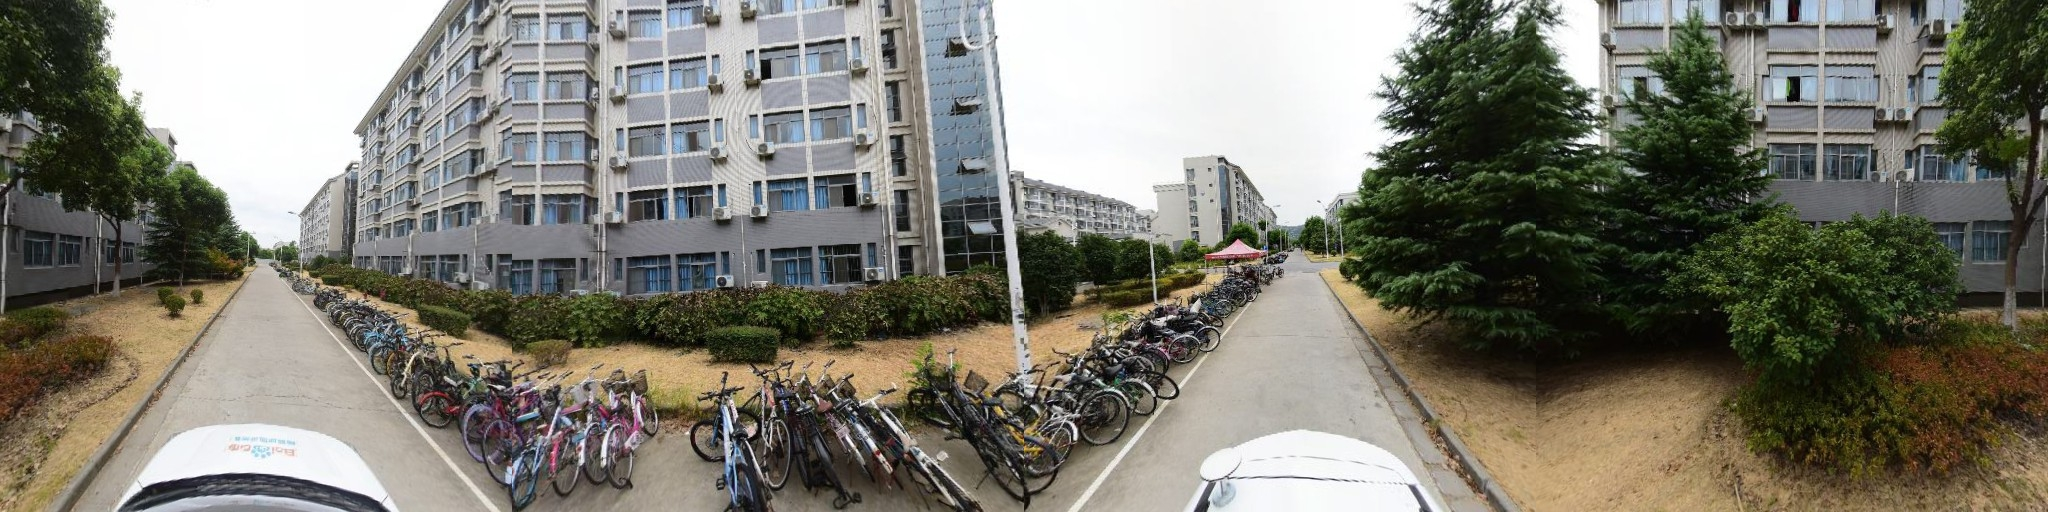

In [50]:
img = 'D:/desk/JNU/test/2_out.jpg'
img = Image.open(img)
#img = img.resize((512,512))
img

In [51]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 512, 2048])


In [53]:
import torch
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth
    predicted_depth.shape
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=pixel_values.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()
#formatted = (prediction * 255 / np.max(prediction)).astype("uint8")
#depth = Image.fromarray(formatted)    #show gray img

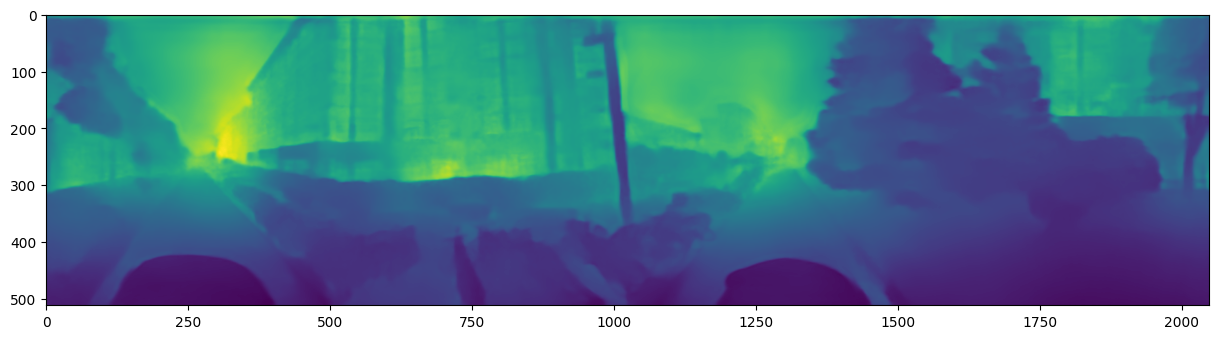

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.imshow(prediction)
plt.savefig("D:/desk/JNU/imgdepth.jpg", dpi = 600)

# 图像分割

In [1]:
from PIL import Image
image = 'D:/desk/JNU/test/2_out.jpg'
image = Image.open(image)

In [20]:
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
inputs = processor(images=image, return_tensors="pt")

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")
outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
#results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]  #instance seg

d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
`label_ids_to_fuse` unset. No instance will be fused.


In [6]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

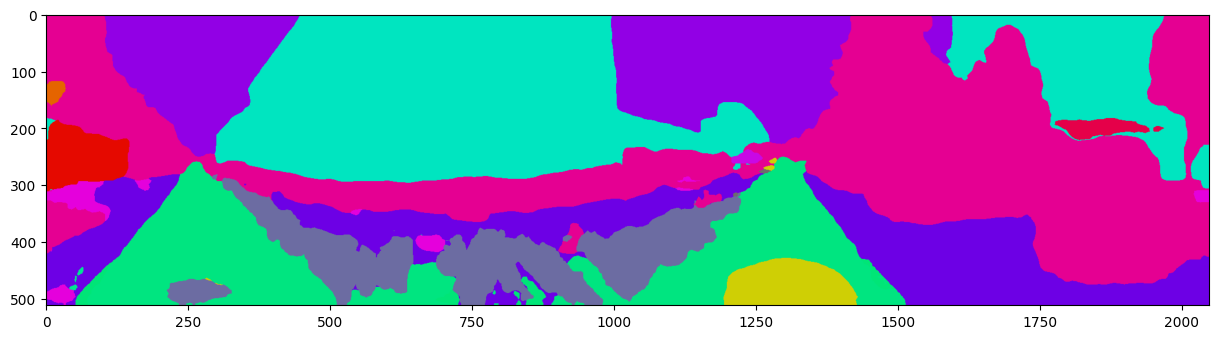

In [32]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_semantic_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.1 + color_seg * 0.9
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [24]:
color_seg.shape

(512, 2048, 3)

<font color=black size=5 face=雅黑>6.提取图像特征（使用ViT）</font>

In [42]:
# Import libraries
import torch
from transformers import ViTModel
import os
from torchvision import transforms
# Import tqdm class from tqdm module
from tqdm import tqdm

# Load ViT model
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# Define a folder path that contains all the images
folder_path = "D:/desk/JNU/test"

# Define a transform to resize and normalize the images
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an empty list to store the tensors
tensor_list = []

# Use torch.no_grad() to disable gradient computation
with torch.no_grad():
  # Loop through all the images in the folder with tqdm progress bar
  for file_name in tqdm(os.listdir(folder_path)):
    # Check if the file is an image
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
      # Load the image using PIL and apply the transform
      image = Image.open(os.path.join(folder_path, file_name))
      image = transform(image)

      # Add a batch dimension to the image tensor
      image = image.unsqueeze(0)

      # Get the output of the model
      output = model(image)

      # Get the pooler_output attribute from the outputs and flatten it
      fc_layer_tensor = output.pooler_output.flatten()

      # Append the tensor to the list
      tensor_list.append(fc_layer_tensor)

# Stack all the tensors in the list into a 2d tensor
big_tensor = torch.stack(tensor_list)


# Use torch.numpy() to convert a tensor to an array
big_array = big_tensor.numpy()

# Print the array
print(big_array)
print(big_array.shape)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00

[[-0.90654737 -0.47022992 -0.27209657 ...  0.00991273 -0.06675429
   0.2860053 ]
 [-0.84335226 -0.35680962 -0.5063159  ... -0.40282118 -0.5887282
   0.18422289]
 [-0.7185681  -0.27478608  0.18451595 ...  0.04726718 -0.44130585
   0.20636249]]
(3, 768)


In [36]:
import pandas as pd
# convert array into dataframe
np.save('D:/desk/JNU/imgfeature_embeddings.npy', big_array)
DF = pd.DataFrame(big_array)
 
# save the dataframe as a csv file
DF.to_csv("D:/desk/test.csv")

<font color=black size=5 face=雅黑>7.图像降维聚类</font>

In [101]:
import hdbscan
import umap.umap_ as umap
import numpy as np
big_array=np.load('D:/desk/JNU/imgfeature_embeddings.npy')

In [ ]:
fit = umap.UMAP(n_neighbors=15,n_components=2,min_dist=0.0,metric='cosine')
%time u = fit.fit_transform(data)
plt.scatter(x=u[:,0],y=u[:,1],s=1)

In [ ]:
# umap_embeddings=embeddings
for num in [8,10,20,40,60,80]:
  # umap_embeddings=embeddings
  cluster = hdbscan.HDBSCAN(min_cluster_size=num,
                metric='euclidean',                      
                cluster_selection_method='eom',
                ).fit(u)
    print(len(set(cluster_bert.labels_.tolist())))

cluster = hdbscan.HDBSCAN(min_cluster_size=40,
                metric='euclidean',                      
                cluster_selection_method='eom',
                ).fit(u)
print(len(set(cluster.labels_.tolist())))

C:\Users\浩然\AppData\Local\Temp\ipykernel_3856\2911664100.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y,s=10 ,label=f"Cluster {i+1}",cmap="Spectral")


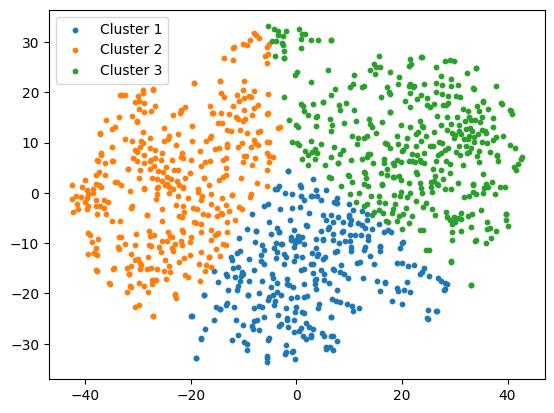

In [99]:
# Import matplotlib library
import matplotlib.pyplot as plt

# Define a list of colors for each cluster label
color='#BDBDBD'

# Loop through each cluster label
for i in range(len(np.unique(cluster.labels_))):
  # Get the indices of the points that belong to this cluster
  indices = cluster.labels_ == i

  # Get the corresponding reduced_array values for these points
  x = X_embedded[indices, 0]
  y = X_embedded[indices, 1]

  # Plot these points with the corresponding color and label
  plt.scatter(x, y, c=color,s=0.1)
  plt.scatter(x, y,s=10 ,label=f"Cluster {i+1}",cmap="Spectral")

# Add a legend and show the plot
plt.legend()
plt.savefig("D:/desk/JNU/test.jpg", dpi = 600)
plt.show()

In [141]:
import pandas as pd
df=pd.read_csv('D:/desk/JNU/test.csv')
df.head()

,0,1,label
0,3.715320,12.001584,-1
1,6.399233,13.174504,-1
2,5.841242,12.249801,0
3,6.889994,11.319362,-1
4,4.945530,12.289060,2


In [146]:
import os
folder_path = "D:/desk/JNU/save_joint_images"
list = os.listdir(dir_path)
df['id']=list
df.to_csv('D:/desk/JNU/test.csv',index=None)